In [88]:
import numpy as np
import pandas as pd
import os
import laspy
from scipy.spatial import ConvexHull, Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import morphology
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KDTree
from pykrige.ok import OrdinaryKriging

In [89]:
directory = os.getcwd()
directory

'c:\\Users\\tttajude\\MScResearch\\MainFiles'

In [90]:
infile = os.path.join(directory, "OriginalData", "Knee1a2a.las")
#infile = os.path.join(directory, "OriginalData", "visualisationb.las")
#infile = os.path.join(directory, "Knee1ac2a.las")
las_file = laspy.read(infile)
#las_file = laspy.read("C:\\Users\\tttajude\\Research\\OriginalData\\point_define1k3a.las")
#las_file = laspy.read("C:\\Users\\tttajude\\Research\\OriginalData\\point_define4ka5.las")
#las_file = laspy.read("C:\\Users\\tttajude\\Research\\OriginalData\\visualisationb.las")
#las_file = laspy.read("C:\\Users\\tttajude\\Research\\knee1ac2.las")
#las_file = laspy.read("C:\\Users\\tttajude\\Research\\OriginalData\\Knee1a2a.las")

In [91]:
#print(lidar_data.columns)
dimension = list(las_file.point_format.dimension_names)
print(dimension)

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'Coord.__Z', 'Coord.__Y', 'Coord.__X']


In [92]:
# Define the coordinate system
import pyproj
crs = pyproj.CRS.from_epsg(32617) #6543, 4326
las_file.header.srs = pyproj.CRS.from_epsg(32617).to_wkt()

In [93]:
# Create a grid that covers the entire area of the stockpile
#x_min, y_min, z_min, x_max, y_max, z_max = las_file.get_header()
xi = las_file.x
yi = las_file.y
zi = las_file.z

# Print the summary of x, y, and z values
print("Summary of X values:")
print(f"  Minimum: {np.min(xi)}")
print(f"  Maximum: {np.max(xi)}")
print("")

print("Summary of Y values:")
print(f"  Minimum: {np.min(yi)}")
print(f"  Maximum: {np.max(yi)}")
#print(f"  Mean: {np.mean(y_points)}")
#print(f"  Median: {np.median(y_points)}")
#print(f"  Standard Deviation: {np.std(y_points)}")
print("")

print("Summary of Z values:")
print(f"  Minimum: {np.min(zi)}")
print(f"  Maximum: {np.max(zi)}")
print("")

Summary of X values:
  Minimum: 733833.674683
  Maximum: 733837.030212

Summary of Y values:
  Minimum: 3966853.781128
  Maximum: 3966856.118408

Summary of Z values:
  Minimum: 0.6652509999999999
  Maximum: 1.714337



In [94]:
# Select only points classified as non-ground points (class code 0)
las_file = las_file.points[las_file.classification == 0]

# get the x, y, and z coordinates of the points
x = las_file.x
y = las_file.y
z = las_file.z

In [95]:
#convert las lidar points to numpy array
points = np.vstack((las_file.x, las_file.y, las_file.z)).transpose() 
point_cloud = np.vstack((las_file.x, las_file.y, las_file.z)).transpose()
print(f"Number of points: {points.shape[0]}")

Number of points: 43368


In [96]:
# Perform clustering on the non-ground points
dbscan = DBSCAN(eps=0.015, min_samples=10)
#labels = dbscan.fit_predict(points)
labels = dbscan.fit_predict(np.column_stack((x, y, z)))

# get the number of clusters
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)      
print("Number of knees identified:", num_clusters)

Number of knees identified: 6


In [97]:
def compute_dsm_volume(cluster_x, cluster_y, cluster_z, grid_resolution):
    # Create a 2D grid covering the XY plane of the cluster points
    x_min, x_max = np.min(cluster_x), np.max(cluster_x)
    y_min, y_max = np.min(cluster_y), np.max(cluster_y)
    #grid_x = np.arange(x_min, x_max, grid_resolution)
    #grid_y = np.arange(y_min, y_max, grid_resolution)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_resolution),
                         np.arange(y_min, y_max, grid_resolution))

    # Interpolate Z values onto the grid using 'nearest' method to handle missing values
    grid_z = griddata((cluster_x, cluster_y), cluster_z, (xx, yy), method='nearest')
    #OK = OrdinaryKriging(cluster_x, cluster_y, cluster_z, variogram_model='exponential', verbose=False, enable_plotting=False)
    #grid_z, sigma = OK.execute('grid', grid_x, grid_y)

    # Compute the volume for each grid cell
    dz = grid_z - np.min(grid_z)  # Height of each grid cell from the DSM
    area = grid_resolution ** 2  # Area of each grid cell (assuming square cells)
    volume = np.sum(dz * area)

    return xx, yy, grid_z, volume

#grid_resolution = 0.05 # You specified this resolution
grid_resolution = [0.05, 0.01, 0.005]

In [98]:
def return_first(num_clusters):
    for i in range(num_clusters):
        if np.any(labels == i):
            cluster_points = np.where(labels == i)[0][0]
            cluster_x = x[cluster_points]
            cluster_y = y[cluster_points]
            cluster_z = z[cluster_points]
            return cluster_x, cluster_y, cluster_z

In [99]:
# Get the indices of points belonging to the first cluster
first_cluster_indices = np.where(labels == 0)[0]

# Extract points of the first cluster
x1 = x[first_cluster_indices]
y1 = y[first_cluster_indices]
z1 = z[first_cluster_indices]

In [100]:
# Parameters for the conical geometry
radius = 0.25273
height = 0.670212

# Calculate centroid of the point cloud
centroid = np.mean(np.vstack((x1, y1, z1)), axis=1)

# Calculate the minimum z-coordinate of the point cloud
min_z_cloud = np.min(z1)

# Calculate the z-coordinate of the cone's base
z_base_cone = min_z_cloud

# Create meshgrid for the conical surface
theta_mesh = np.linspace(0, 2*np.pi, 100)
z_mesh = np.linspace(0, height, 100)
theta_mesh, z_mesh = np.meshgrid(theta_mesh, z_mesh)

# Compute coordinates of the conical surface centered at the centroid
x_cone = centroid[0] + radius * (1 - z_mesh/height) * np.cos(theta_mesh)
y_cone = centroid[1] + radius * (1 - z_mesh/height) * np.sin(theta_mesh)
z_cone = z_base_cone + z_mesh  # Align the base of the cone with the minimum z-coordinate of the point cloud

In [101]:
#num_clusters = num_clusters[0:2]
print("Number of knees identified:", num_clusters)

Number of knees identified: 6


0.056901627499999996
0.0560405743
0.05613500565


C:\Users\tttajude\AppData\Local\Temp\ipykernel_68084\2602112477.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  artists = legend.legendHandles


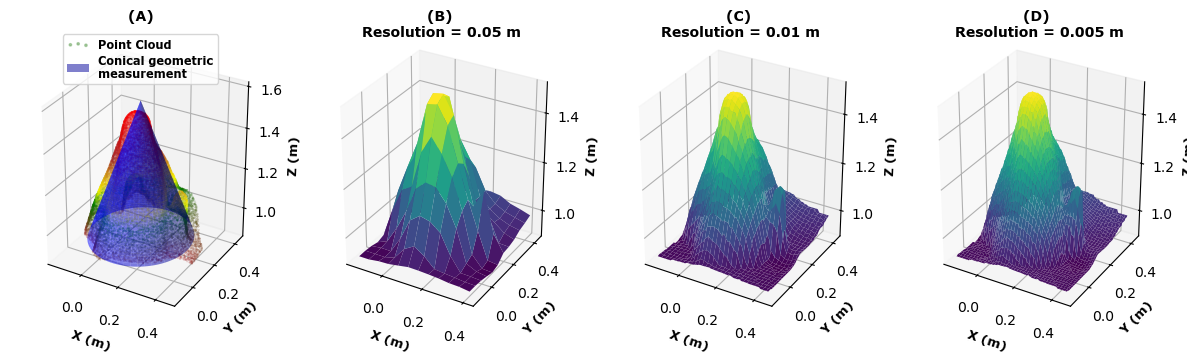

In [102]:
# Define the gradient colors for the colormap
#colors = [(0.0, 'blue'), (0.3111, 'green'), (0.645555, 'yellow'), (1.0, 'red')]
colors = [(0.0, 'brown'), (0.2566, 'green'), (0.345555, 'yellow'), (0.6111, 'brown'), (1.0, 'red')]
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('gradient', colors)

# Create a subplot for each cluster
cluster_points = np.where(labels == 0)[0]
cluster_x = x[cluster_points]
cluster_y = y[cluster_points]
cluster_z = z[cluster_points]

# Create a subplot with multiple columns for different grid resolutions
grid_resolution = [0.05, 0.01, 0.005]
num_resolutions = len(grid_resolution)
fig, axes = plt.subplots(1, num_resolutions + 1, figsize=(15, 5), subplot_kw={'projection': '3d'})

# Scatter plot of the original point cloud with the custom colormap
scatter = axes[0].scatter(cluster_x, cluster_y, cluster_z, c=cluster_z, alpha = 0.3, cmap=cmap, s=0.1, marker='o', label = 'Point Cloud')
axes[0].plot_surface(x_cone, y_cone, z_cone, color='b', alpha=0.5, label='Conical geometric\nmeasurement')   
axes[0].set_xlabel('X (m)', fontsize=9, fontdict={'family': 'Verdana', 'weight': 'bold'})
axes[0].set_ylabel('Y (m)', fontsize=9, fontdict={'family': 'Verdana', 'weight': 'bold'})
axes[0].set_zlabel('Z (m)', fontsize=9, fontdict={'family': 'Verdana', 'weight': 'bold'})
axes[0].autoscale(enable=True, axis='both')
axes[0].set_box_aspect([0.9, 0.9, 1.1])  # Adjust the aspect ratio of the plot
axes[0].set_title("(A) \n", fontsize=10, fontdict={'family': 'Verdana', 'weight': 'bold'})
    
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.1f}'.format(x % 1)))
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}'.format(y % 1)))

legend = axes[0].legend(loc='upper right', fontsize=8, bbox_to_anchor=(0.8, 1.06), scatterpoints=3)
leg = axes[0].get_legend()
    
for text in leg.get_texts():
    text.set_fontfamily('Verdana')
    text.set_weight('bold')
    text.set_fontsize(8.2)

# Get the artists in the legend
artists = legend.legendHandles

# Set the marker size for the scatter points in the legend
for artist in artists:
    artist._sizes = [3]
    
num = ["(B)", 
       "(C)", 
       "(D)"]

# Compute and plot DSM for each resolution in the current cluster's subplot
for j, (resolution, b) in enumerate(zip(grid_resolution, num)):
    cluster_xx, cluster_yy, cluster_dsm, cluster_volume = compute_dsm_volume(cluster_x, cluster_y, cluster_z, resolution)
    print(cluster_volume)
    ax = axes[j + 1]
    ax.plot_surface(cluster_xx, cluster_yy, cluster_dsm, cmap='viridis')
    ax.set_xlabel('X (m)', fontsize=9, fontdict={'family': 'Verdana', 'weight': 'bold'})
    ax.set_ylabel('Y (m)', fontsize=9, fontdict={'family': 'Verdana', 'weight': 'bold'})
    ax.set_zlabel('Z (m)', fontsize=9, fontdict={'family': 'Verdana', 'weight': 'bold'})
    ax.set_title(f"{b} \nResolution = {resolution} m", fontsize=10, fontdict={'family': 'Verdana', 'weight': 'bold'})
    #ax.set_title(f"{b} \nResolution = {resolution * 100} cm", fontsize=10, fontdict={'family': 'Verdana', 'weight': 'bold'})
    ax.autoscale(enable=True, axis='both')
    ax.set_box_aspect([0.9, 0.9, 1.1])  # Adjust the aspect ratio of the plot

   # Formatting tick labels for x and y axes
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.1f}'.format(x % 1)))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}'.format(y % 1)))

# Add a colorbar for the scatter plot
#cbar = plt.colorbar(scatter, ax=axes[0])
#cbar.set_label('Z', rotation=90)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.12, hspace=0)  # You can adjust the values as needed
    
# Directory to save the plots
#save_directory = "plots/"
#plt.savefig(f"{save_directory}cluster_{i+1}_plot.png", dpi=150)
plt.savefig(f"cluster_{i+1}_plot.png", dpi=300)

#fig.suptitle(f"Cluster {i+1} DSMs at Different Resolutions")
plt.show()

In [103]:
# Plot the point cloud
ax.scatter(x1, y1, z1, c=z1, cmap=cmap, s=1.2, marker='o', alpha=0.2, label='Point Cloud')

# Plot the conical geometry
ax.plot_surface(x_cone, y_cone, z_cone, color='b', alpha=0.3, label='Conical Geometry \nmeasurement')

# Set labels and legend
ax.set_xlabel('X (m)', fontsize=10, fontdict={'family': 'Verdana', 'weight': 'bold'})
ax.set_ylabel('Y (m)', fontsize=10, fontdict={'family': 'Verdana', 'weight': 'bold'})
ax.set_zlabel('Z (m)', fontsize=10, fontdict={'family': 'Verdana', 'weight': 'bold'})
ax.legend()

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.2f}'.format(x % 1)))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.2f}'.format(y % 1)))

ax.legend(loc='upper left', bbox_to_anchor=(0.24, 1))
ax.tick_params(axis='x', which='major', pad=3)
ax.tick_params(axis='y', which='major', pad=3)

ax.autoscale(enable=True, axis='both')
ax.set_box_aspect([0.9, 0.9, 1.1])  # Adjust the aspect ratio of the plot

leg = ax.get_legend()
    
for text in leg.get_texts():
    text.set_fontfamily('Berlin Sans FB')
    text.set_fontsize(13)


plt.savefig('lidar_geometryb.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

In [104]:
# Create a subplot for each cluster
for i in range(num_clusters):
    cluster_points = np.where(labels == i)[0]
    cluster_x = x[cluster_points]
    cluster_y = y[cluster_points]
    cluster_z = z[cluster_points]

    # Create a subplot with multiple columns for different grid resolutions
    grid_resolution = [0.05, 0.01, 0.005]
    num_resolutions = len(grid_resolution)

    # Compute and plot DSM for each resolution in the current cluster's subplot
    for j, (resolution, b) in enumerate(zip(grid_resolution, num)):
        cluster_xx, cluster_yy, cluster_dsm, cluster_volume = compute_dsm_volume(cluster_x, cluster_y, cluster_z, resolution)
        print(cluster_volume)

0.056901627499999996
0.0560405743
0.05613500565
0.002363660000000001
0.0021720792000000004
0.002146509950000001
0.0013725124999999982
0.0015039801000000011
0.001468492325000001
0.0
4.56040000000002e-06
3.826350000000017e-06
0.043946465
0.04109676600000001
0.040776442275000005
2.159500000000009e-05
2.3326400000000025e-05
2.1413725000000037e-05
